<a href="https://colab.research.google.com/github/Pranav03125/Intergrated_UFFT/blob/main/EC2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Step 1: Data Loading and Initial Overview
import pandas as pd

# Load the cleaned dataset (CSV version for ease in Colab)
file_path = '/Data_EF Laundry (1).xlsx'  # Update path if needed
df = pd.read_excel(file_path)

# Display first 5 rows to understand structure
print("First 5 rows of the dataset:")
print(df.head())

# Dataset shape and column info
print("\nDataset shape (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns)

# Data types and non-null counts
print("\nDataset info:")
df.info()

# Check for missing values count per column
print("\nMissing values count per column:")
print(df.isnull().sum())

# Basic descriptive statistics for numeric columns
print("\nDescriptive statistics summary:")
print(df.describe())


First 5 rows of the dataset:
   Set  ESA cm2   flowrate  Volatge  Time  LAS Absorbance  Vol of FAS  \
0    4     2840  1.88L/min        6     0           6.435       10.00   
1    4     2840  1.88L/min        6     5           6.006       10.10   
2    4     2840  1.88L/min        6    10           5.541       10.20   
3    4     2840  1.88L/min        6    15           4.821       10.40   
4    4     2840  1.88L/min        6    20           4.339       10.45   

       COD      COD %  Turbidity       LAS    pH  Current        CD  Power  \
0  50.9184   0.000000        132  1.245682  7.80    3.086  0.001087   19.3   
1  49.6128   2.564103         60  1.136329  7.50    3.199  0.001126   19.2   
2  48.3072   5.128205         42  1.017801  7.30    3.049  0.001074   18.3   
3  47.0000   7.695450         35  0.834273  7.28    2.942  0.001036   17.6   
4  45.8000  10.052162         23  0.711411  7.26    2.865  0.001009   17.2   

   Aluminium (LAS)  
0         0.000000  
1         0.000038  


In [6]:
# Step 2: Data Cleaning and Preprocessing

from sklearn.impute import SimpleImputer

# Drop the column "Aluminium (LAS)" as per project requirements, if present
if 'Aluminium (LAS)' in df.columns:
    df = df.drop(columns=['Aluminium (LAS)'])

# If 'flowrate' is a string with units like "1.88L/min", convert it to float
if df['flowrate'].dtype == object:
    df['flowrate'] = df['flowrate'].str.replace('L/min', '').astype(float)

# Check missing values before imputation
print("Missing values before imputation:")
print(df.isnull().sum())

# List of columns with missing values to impute
num_cols_with_missing = ['LAS Absorbance', 'LAS', 'pH', 'Current', 'CD', 'Power']

# Impute missing numeric values with median
imputer = SimpleImputer(strategy='median')
df[num_cols_with_missing] = imputer.fit_transform(df[num_cols_with_missing])

# Encode 'Set' column as categorical type for modeling
df['Set'] = df['Set'].astype('category')

# Confirm no missing values remain
print("\nMissing values after imputation:")
print(df.isnull().sum())

# Show updated data types and preview data
print("\nData types after cleaning:")
print(df.dtypes)
print("\nData preview after cleaning:")
print(df.head())


Missing values before imputation:
Set                0
ESA cm2            0
flowrate           0
Volatge            0
Time               0
LAS Absorbance    35
Vol of FAS         0
COD                0
COD %              0
Turbidity          0
LAS               35
pH                 6
Current            6
CD                 6
Power             41
dtype: int64

Missing values after imputation:
Set               0
ESA cm2           0
flowrate          0
Volatge           0
Time              0
LAS Absorbance    0
Vol of FAS        0
COD               0
COD %             0
Turbidity         0
LAS               0
pH                0
Current           0
CD                0
Power             0
dtype: int64

Data types after cleaning:
Set               category
ESA cm2              int64
flowrate           float64
Volatge              int64
Time                 int64
LAS Absorbance     float64
Vol of FAS         float64
COD                float64
COD %              float64
Turbidity           

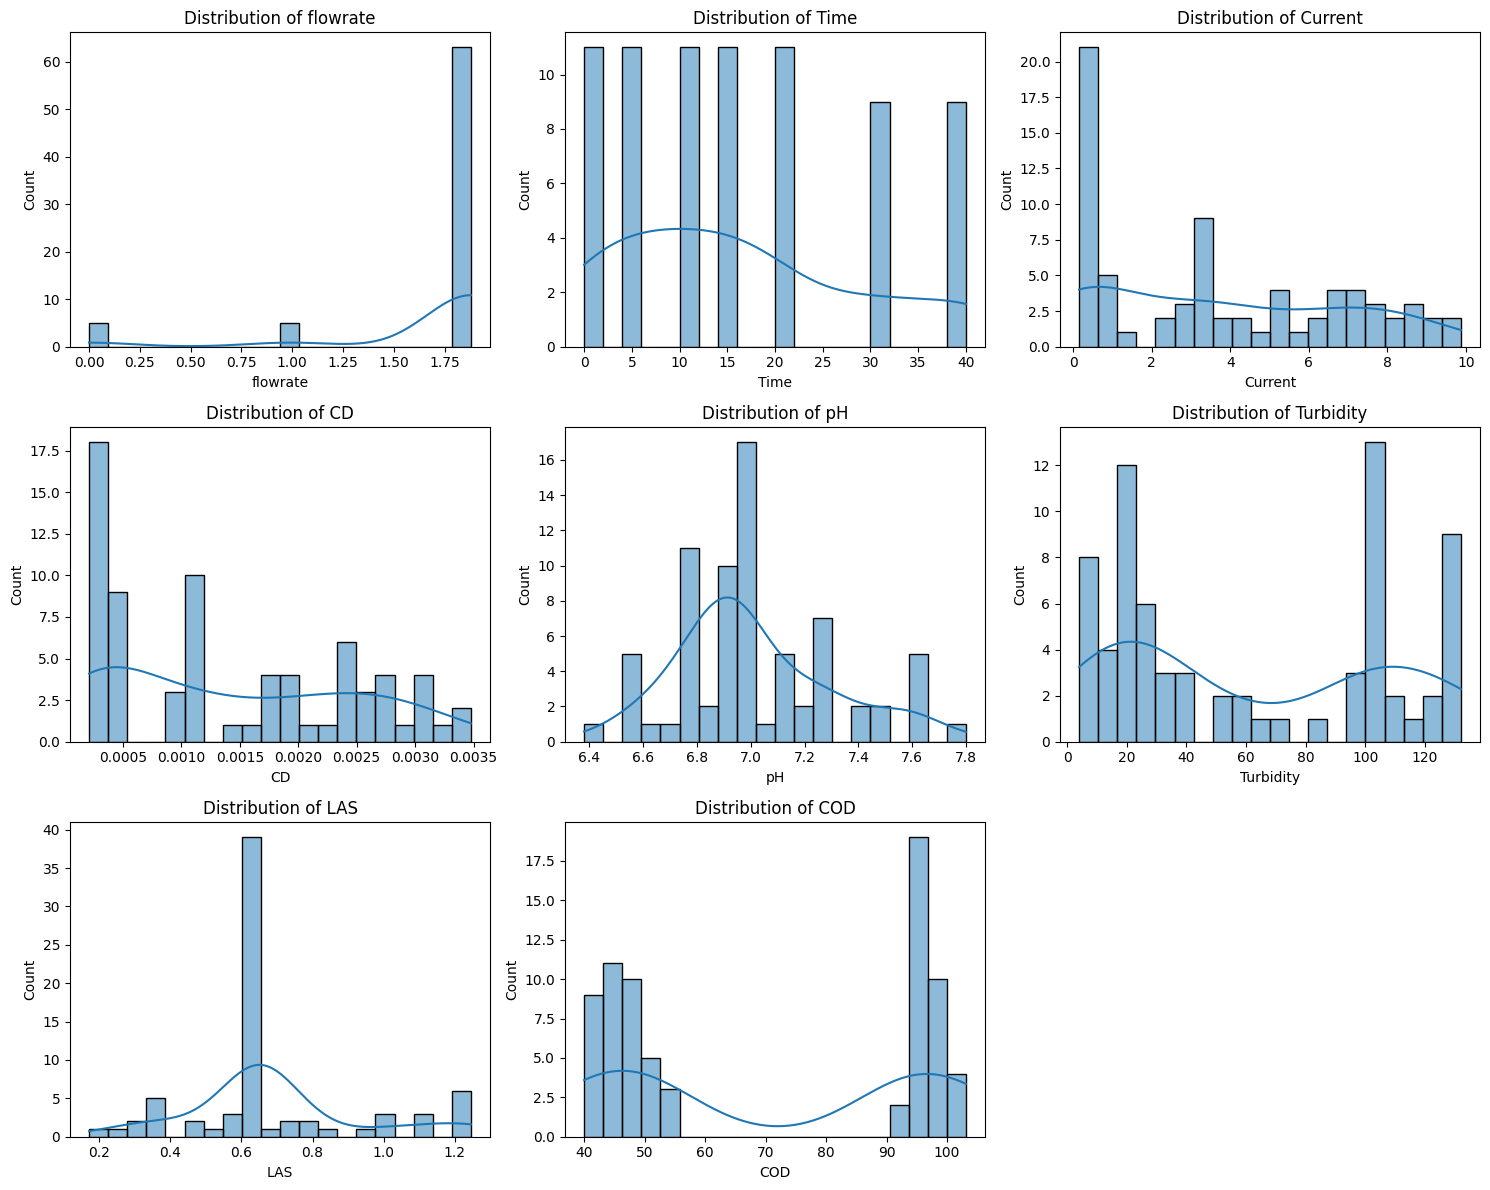

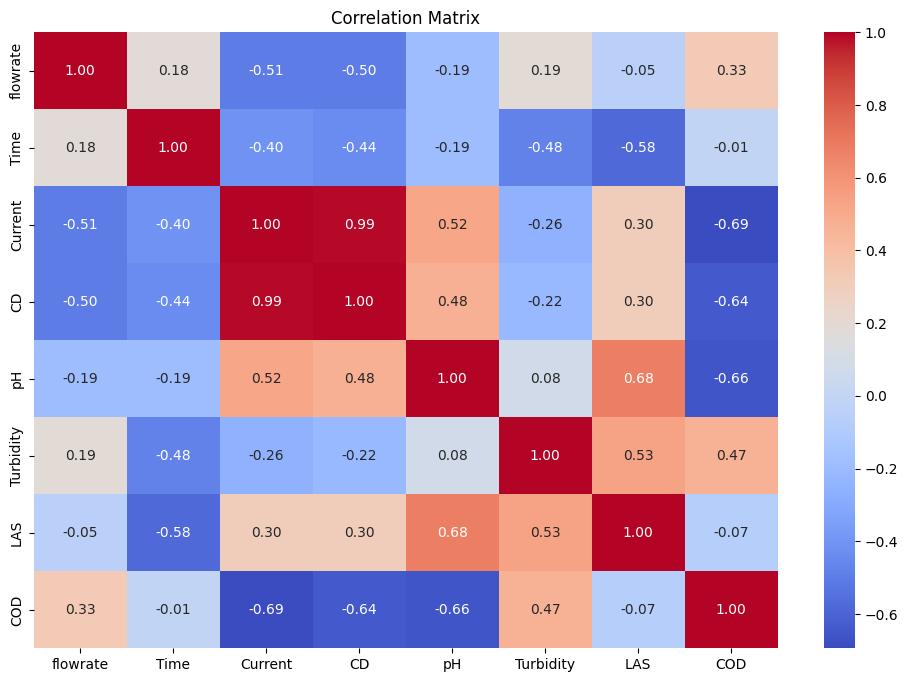

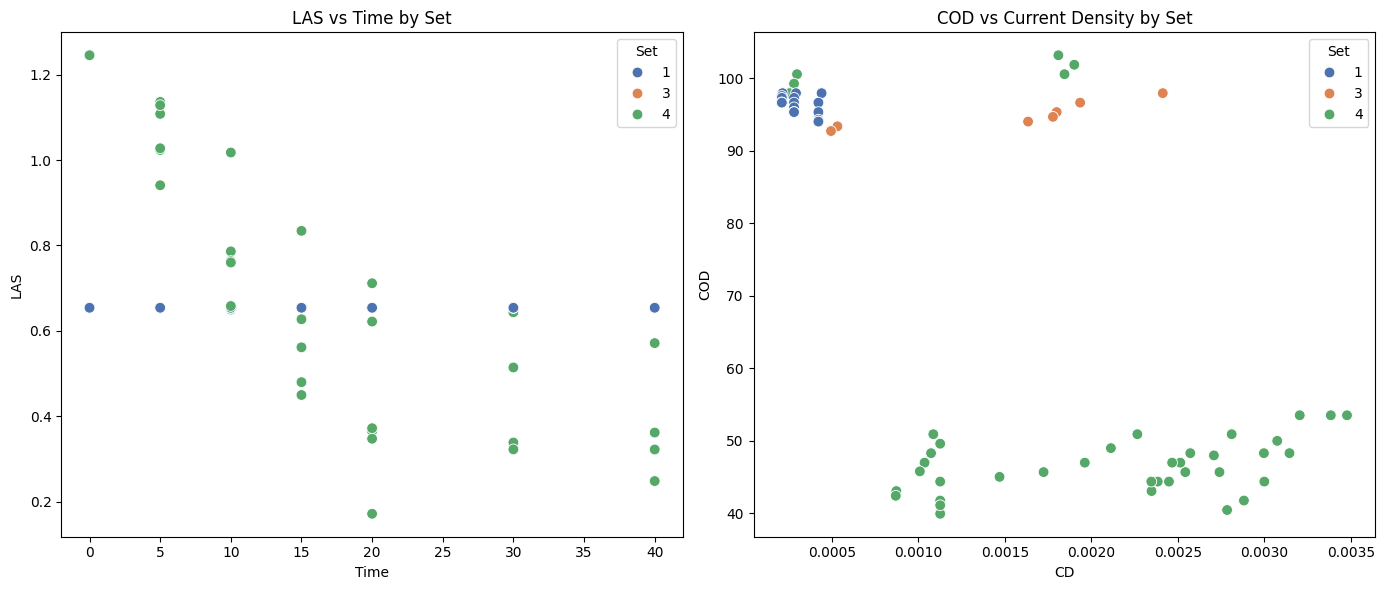

In [7]:
# Step 3: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution plots for key numeric features and targets
key_vars = ['flowrate', 'Time', 'Current', 'CD', 'pH', 'Turbidity', 'LAS', 'COD']

plt.figure(figsize=(15, 12))
for i, var in enumerate(key_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True, bins=20)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# 2. Correlation matrix heatmap including targets and key features
plt.figure(figsize=(12, 8))
corr_matrix = df[['flowrate', 'Time', 'Current', 'CD', 'pH', 'Turbidity', 'LAS', 'COD']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 3. Scatter plots of LAS and COD vs Time and Current Density (CD) to check for trends
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Time', y='LAS', data=df, hue='Set', palette='deep', s=60)
plt.title('LAS vs Time by Set')

plt.subplot(1, 2, 2)
sns.scatterplot(x='CD', y='COD', data=df, hue='Set', palette='deep', s=60)
plt.title('COD vs Current Density by Set')

plt.tight_layout()
plt.show()


In [8]:
# Step 4: Feature selection/engineering and train-test split

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Keep CD (drop Current and Volatge, ESA), drop LAS Absorbance if treating as proxy of LAS (optional toggle)
drop_cols = ['Volatge', 'ESA cm2', 'Current']
# If you want a pure process-input model (no lab proxies), also drop 'LAS Absorbance'
drop_lab_proxy = True
if drop_lab_proxy and 'LAS Absorbance' in df.columns:
    drop_cols.append('LAS Absorbance')

df_model = df.drop(columns=drop_cols)

# Categorical: One-hot encode 'Set'
df_model = pd.get_dummies(df_model, columns=['Set'], drop_first=True)

# Features and targets
target_cols = ['LAS', 'COD']
X = df_model.drop(columns=target_cols)
y = df_model[target_cols]

# Train-test split (stratify on nothing due to regression, keep random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X shape:", X.shape, "y shape:", y.shape)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Final feature columns:", list(X.columns))


X shape: (73, 10) y shape: (73, 2)
Train: (58, 10) Test: (15, 10)
Final feature columns: ['flowrate', 'Time', 'Vol of FAS', 'COD %', 'Turbidity', 'pH', 'CD', 'Power', 'Set_3', 'Set_4']


In [9]:
# Step 5: Model Training and Evaluation

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy

# Numeric columns already encoded; for ridge, scale inputs
num_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='drop'
)

def eval_model(name, model, Xtr, Xte, ytr, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
        # Calculate RMSE by taking the square root of the mean squared error
        rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
        r2 = r2_score(y_true, y_pred, multioutput='raw_values')
        return mae, rmse, r2
    tr_mae, tr_rmse, tr_r2 = metrics(ytr, ytr_pred)
    te_mae, te_rmse, te_r2 = metrics(yte, yte_pred)
    print(f"\n{name}")
    print(" Train  MAE:", np.round(tr_mae, 4), " RMSE:", np.round(tr_rmse, 4), " R2:", np.round(tr_r2, 4))
    print(" Test   MAE:", np.round(te_mae, 4), " RMSE:", np.round(te_rmse, 4), " R2:", np.round(te_r2, 4))
    return yte_pred

# 1. Ridge (baseline linear model)
ridge_pipe = Pipeline([
    ('prep', preprocessor),
    ('reg', MultiOutputRegressor(Ridge(alpha=1.0, random_state=42)))
])
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = eval_model("Ridge (multi-output)", ridge_pipe, X_train, X_test, y_train, y_test)

# 2. RandomForest (multi-output)
rf_pipe = Pipeline([
    ('prep', 'passthrough'),
    ('reg', MultiOutputRegressor(RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = eval_model("RandomForest (multi-output)", rf_pipe, X_train, X_test, y_train, y_test)

# 3. GradientBoosting (multi-output)
gbr_pipe = Pipeline([
    ('prep', 'passthrough'),
    ('reg', MultiOutputRegressor(GradientBoostingRegressor(n_estimators=600, learning_rate=0.03, random_state=42)))
])
gbr_pipe.fit(X_train, y_train)
y_pred_gbr = eval_model("GradientBoosting (multi-output)", gbr_pipe, X_train, X_test, y_train, y_test)


Ridge (multi-output)
 Train  MAE: [0.0577 1.2301]  RMSE: [0.0747 1.5548]  R2: [0.9032 0.9962]
 Test   MAE: [0.0791 1.6422]  RMSE: [0.1007 1.9676]  R2: [0.8506 0.9939]

RandomForest (multi-output)
 Train  MAE: [0.0121 0.2533]  RMSE: [0.0243 0.3705]  R2: [0.9897 0.9998]
 Test   MAE: [0.052 0.609]  RMSE: [0.0825 0.9134]  R2: [0.8997 0.9987]

GradientBoosting (multi-output)
 Train  MAE: [0.0001 0.0019]  RMSE: [0.0001 0.0026]  R2: [1. 1.]
 Test   MAE: [0.0481 0.399 ]  RMSE: [0.0764 0.6125]  R2: [0.914  0.9994]


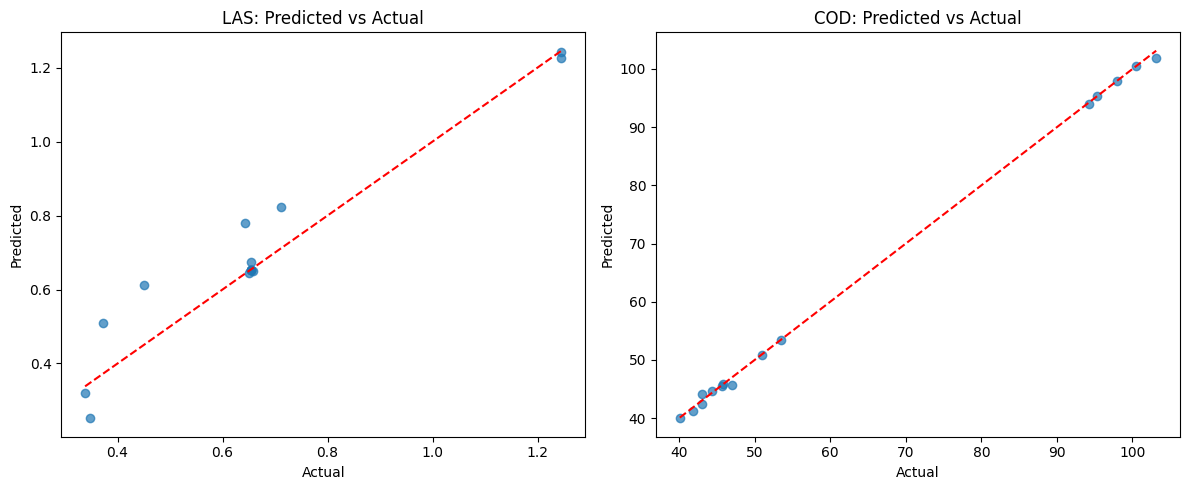

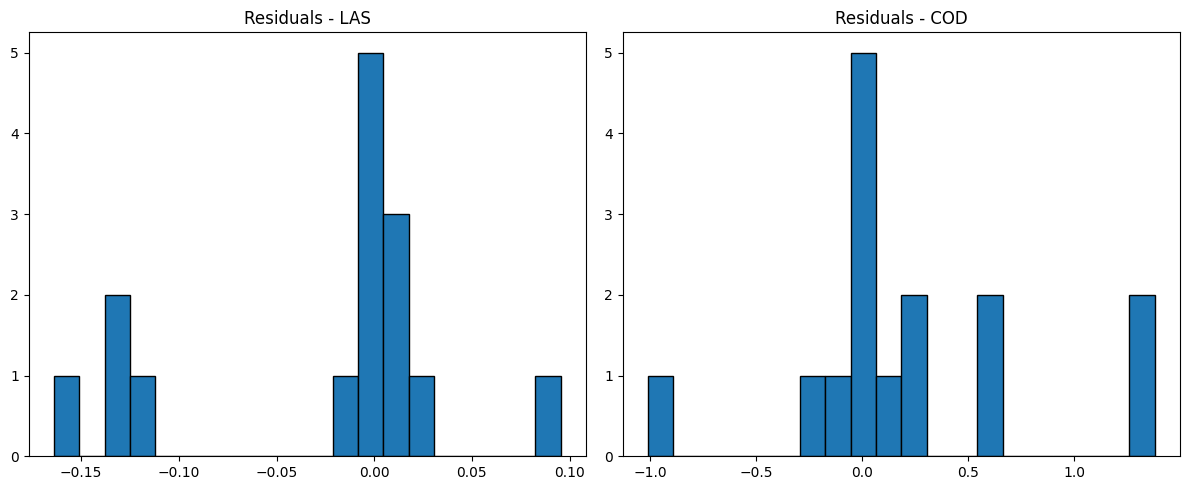

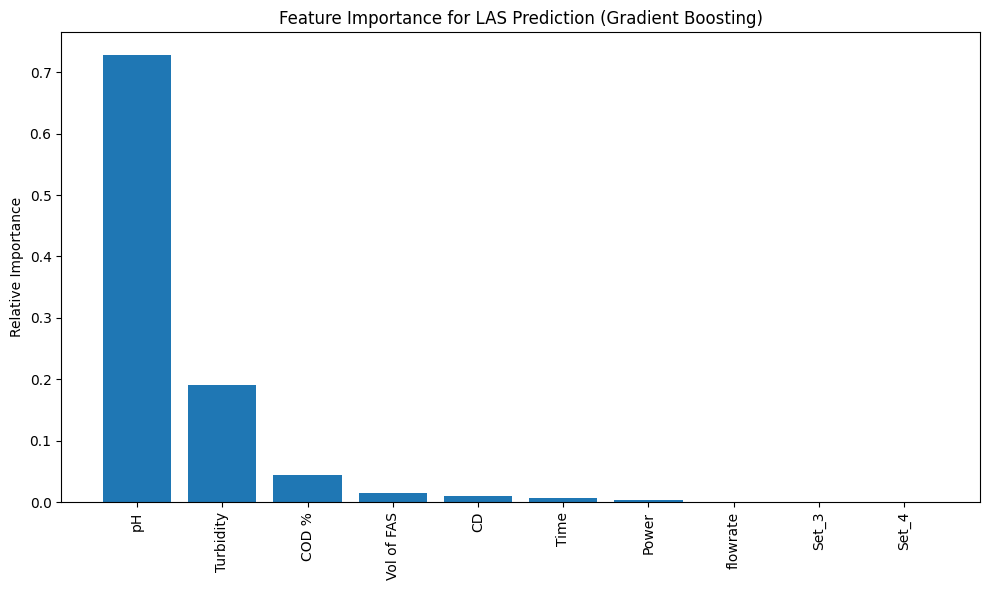

In [10]:
# Step 6: Model Diagnostics and Feature Importance

import matplotlib.pyplot as plt
import numpy as np

best_pipe = gbr_pipe  # Gradient Boosting model selected
y_pred = best_pipe.predict(X_test)

# Predicted vs Actual plots for LAS and COD
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(['LAS', 'COD']):
    axs[i].scatter(y_test[col], y_pred[:, i], alpha=0.7)
    mn, mx = y_test[col].min(), y_test[col].max()
    axs[i].plot([mn, mx], [mn, mx], 'r--')
    axs[i].set_title(f'{col}: Predicted vs Actual')
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
plt.tight_layout()
plt.show()

# Residual histograms for LAS and COD
residuals = y_test.values - y_pred
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(residuals[:, 0], bins=20, edgecolor='black')
axs[0].set_title('Residuals - LAS')
axs[1].hist(residuals[:, 1], bins=20, edgecolor='black')
axs[1].set_title('Residuals - COD')
plt.tight_layout()
plt.show()

# Feature Importance for LAS model in Gradient Boosting (first target model)
estimator_las = best_pipe.named_steps['reg'].estimators_[0]
importances = estimator_las.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance for LAS Prediction (Gradient Boosting)')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.show()


In [11]:
# Step 7: Hyperparameter Tuning (Gradient Boosting, multi-output)

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor


param_grid = {
    'reg__estimator__n_estimators': [300, 600, 900],
    'reg__estimator__learning_rate': [0.02, 0.03, 0.05],
    'reg__estimator__max_depth': [2, 3, 4],
    'reg__estimator__subsample': [0.7, 0.9, 1.0],
}

search_pipe = Pipeline([
    ('reg', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
])

grid = GridSearchCV(
    search_pipe, param_grid=param_grid,
    scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_gbr = grid.best_estimator_

# Evaluate best tuned model
def eval_model(name, model, Xtr, Xte, ytr, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
        # Calculate RMSE by taking the square root of the mean squared error
        rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
        r2 = r2_score(y_true, y_pred, multioutput='raw_values')
        return mae, rmse, r2
    tr_mae, tr_rmse, tr_r2 = metrics(ytr, ytr_pred)
    te_mae, te_rmse, te_r2 = metrics(yte, yte_pred)
    print(f"\n{name}")
    print(" Train  MAE:", np.round(tr_mae, 4), " RMSE:", np.round(tr_rmse, 4), " R2:", np.round(tr_r2, 4))
    print(" Test   MAE:", np.round(te_mae, 4), " RMSE:", np.round(te_rmse, 4), " R2:", np.round(te_r2, 4))
    return yte_pred

_ = eval_model("GradientBoosting (tuned multi-output)", best_gbr, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best params: {'reg__estimator__learning_rate': 0.02, 'reg__estimator__max_depth': 2, 'reg__estimator__n_estimators': 900, 'reg__estimator__subsample': 1.0}

GradientBoosting (tuned multi-output)
 Train  MAE: [0.002  0.0245]  RMSE: [0.0029 0.0398]  R2: [0.9999 1.    ]
 Test   MAE: [0.0419 0.3617]  RMSE: [0.0713 0.5599]  R2: [0.9251 0.9995]


In [12]:
# Step 8.1: Persist tuned model and metadata

import json, joblib, time, platform
from datetime import datetime

best_model = best_gbr   # Use the best_gbr from Step 7
model_path = 'best_las_cod_gbr_tuned.pkl'
joblib.dump(best_model, model_path)

metadata = {
    "model_path": model_path,
    "created_at": datetime.utcnow().isoformat() + "Z",
    "python_version": platform.python_version(),
    "library_versions": {
        "sklearn": __import__('sklearn').__version__,
        "pandas": __import__('pandas').__version__,
        "numpy": __import__('numpy').__version__
    },
    "features": X.columns.tolist(),
    "targets": ["LAS", "COD"],
    "best_params": best_gbr.named_steps['reg'].estimator.get_params(), # Get params from the best estimator
    "train_shape": list(X_train.shape),
    "test_shape": list(X_test.shape)
}
with open('best_las_cod_metadata.json','w') as f:
    json.dump(metadata, f, indent=2)

print("Saved:", model_path, "and best_las_cod_metadata.json")

Saved: best_las_cod_gbr_tuned.pkl and best_las_cod_metadata.json


/tmp/ipython-input-3587538258.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


In [13]:
# Step 8.2: Robust prediction helper (schema-aware)

import numpy as np
import pandas as pd
import joblib, json

# Load artifacts (if reusing in a fresh session)
model = joblib.load('best_las_cod_gbr_tuned.pkl')
with open('best_las_cod_metadata.json') as f:
    meta = json.load(f)
feature_order = meta["features"]

def predict_las_cod(input_dict):
    """
    input_dict: dict of raw feature values using training feature names:
    ['flowrate','Time','Vol of FAS','COD %','Turbidity','pH','CD','Power','Set_3','Set_4']
    Any missing dummy columns will be added as 0; extra keys are ignored.
    Returns: np.array shape (1,2): [LAS_pred, COD_pred]
    """
    row = pd.DataFrame([input_dict])
    # add missing columns as 0, enforce order
    for col in feature_order:
        if col not in row.columns:
            row[col] = 0
    row = row[feature_order]
    preds = model.predict(row)
    return preds[0]

# Example
example = {
    'flowrate': 1.88, 'Time': 20, 'Vol of FAS': 10.2, 'COD %': 10.0,
    'Turbidity': 40, 'pH': 7.1, 'CD': 0.0015, 'Power': 20,
    'Set_3': 0, 'Set_4': 1
}
print("Pred [LAS, COD]:", predict_las_cod(example))


Pred [LAS, COD]: [ 0.63653263 47.21534628]


In [14]:
# Step 8.3: Batch prediction over a DataFrame

def batch_predict(df_raw: pd.DataFrame) -> pd.DataFrame:
    df_in = df_raw.copy()
    for col in feature_order:
        if col not in df_in.columns:
            df_in[col] = 0
    df_in = df_in[feature_order]
    preds = model.predict(df_in)
    out = df_raw.copy()
    out['LAS_pred'] = preds[:,0]
    out['COD_pred'] = preds[:,1]
    return out

# Example batch
df_batch = pd.DataFrame([example, {**example, 'Time': 30, 'CD': 0.0025}])
batch_predict(df_batch)


,flowrate,Time,Vol of FAS,COD %,Turbidity,pH,CD,Power,Set_3,Set_4,LAS_pred,COD_pred
0,1.88,20,10.2,10.0,40,7.1,0.0015,20,0,1,0.636533,47.215346
1,1.88,30,10.2,10.0,40,7.1,0.0025,20,0,1,0.648161,47.155729


In [15]:
# Step 8.4: Simple sweep optimizer (grid) to suggest low LAS & COD regions
# Adjust grids to sensible operating ranges from your data

time_grid = np.linspace(df['Time'].min(), df['Time'].max(), 9)
cd_grid   = np.linspace(df['CD'].min(), df['CD'].max(), 9)
pH_grid   = np.linspace(df['pH'].quantile(0.1), df['pH'].quantile(0.9), 7)

def score_combo(LAS, COD, w_las=0.5, w_cod=0.5):
    # Normalize with empirical mins/max to make weights comparable
    las_min, las_max = df['LAS'].min(), df['LAS'].max()
    cod_min, cod_max = df['COD'].min(), df['COD'].max()
    n_las = (LAS - las_min) / max(1e-6, (las_max - las_min))
    n_cod = (COD - cod_min) / max(1e-6, (cod_max - cod_min))
    return w_las*n_las + w_cod*n_cod

def recommend(flowrate=1.88, vol_fas=10.2, cod_pct=5.0, turb=40, power=20, set3=0, set4=1,
              w_las=0.5, w_cod=0.5, topk=5):
    rows = []
    for t in time_grid:
        for cd in cd_grid:
            for ph in pH_grid:
                row = {
                    'flowrate': flowrate, 'Time': t, 'Vol of FAS': vol_fas, 'COD %': cod_pct,
                    'Turbidity': turb, 'pH': ph, 'CD': cd, 'Power': power,
                    'Set_3': set3, 'Set_4': set4
                }
                las, cod = predict_las_cod(row)
                s = score_combo(las, cod, w_las, w_cod)
                rows.append({**row, 'LAS_pred': las, 'COD_pred': cod, 'score': s})
    recs = pd.DataFrame(rows).sort_values('score').head(topk).reset_index(drop=True)
    return recs

# Example recommendation (equal weights)
recommend(topk=5)


,flowrate,Time,Vol of FAS,COD %,Turbidity,pH,CD,Power,Set_3,Set_4,LAS_pred,COD_pred,score
0,1.88,40.0,10.2,5.0,40,6.692000,0.001844,20,0,1,0.655242,47.835329,0.287607
1,1.88,35.0,10.2,5.0,40,6.692000,0.001844,20,0,1,0.655242,47.835329,0.287607
2,1.88,30.0,10.2,5.0,40,6.692000,0.001844,20,0,1,0.655242,47.840179,0.287645
3,1.88,40.0,10.2,5.0,40,6.954667,0.001844,20,0,1,0.655242,47.842576,0.287664
4,1.88,35.0,10.2,5.0,40,6.823333,0.001844,20,0,1,0.655242,47.842576,0.287664


In [16]:
# Step 8.5: Save artifacts from a sample run
recs = recommend(topk=10)
recs.to_csv('recommended_settings.csv', index=False)
print("Saved recommended_settings.csv")


Saved recommended_settings.csv
